# Project Milestone 2 (P2)

## Context

In this project, we are going to analyze data from...


## The data

...

### Quotebank

...

### Wikidata

...

### Classifier

...


## Project proposal and initial analyses

 ...

## 1. Loading of the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PATH = 'Data/'

### 1.1. Extracting only a sub data frame of interest

We are only interested by the quotes containing ... So to be quicker each time we load the data, we create a sub data frame containing only the quotes of interest. We save it as a pickle file.

#### Extraction and loading functions

In [23]:
def extract_quotes(df, word):
    """
    Create a sub data frame from df with quotations that contains the word (only one for now).
    Inputs:
        * df : data frame of intereset
        * word : single word to extract
    Outputs:
        * df_quotes : dataframe containing the word of reference
    """
    df_quotes = df[df['quotation'].str.contains(word)]
    return df_quotes


def saving_wikidata(path):
    """
    Transforming all the wikidata file in one dataset saved as pickle. 
    This allows to load the file and use it more quickly and easily.
    Inputs:
        * path : pathway where to save the pickle file
    """
    wikidata_all = pd.DataFrame()
    PATH_PARQUET = 'Data_parquet/'
    for i in range(1,16):
        if i < 10:
            DATA_FILE = 'part-0000{}-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet'.format(i)
        else:
            DATA_FILE = 'part-000{}-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet'.format(i)
        print(PATH_PARQUET + DATA_FILE)
        wikidata = pd.read_parquet(PATH_PARQUET + DATA_FILE)
        wikidata_all = pd.concat([wikidata_all, wikidata])
    wikidata_all.to_pickle(path)


def add_columns(column, target, init_df, name_column):
    """
    Check if a target ('politician', 'male', 'female' etc...) is in a certain column.
    If it is, we return True in an additional column (name_column).
    Inputs:
        * column : name of column to search for target
        * target : item of interest 
        * init_df : initial data frame
        * name_column : name of new column of booleans
    Outputs:
        * final_df : dataframe with new column and only rows which contains the item
    """
    final_df = init_df.copy(deep = True)
    final_df[name_column] = final_df[column].apply(lambda x: np.any(x) in target)
    return final_df


def extracting_sub_df(quotebank, wikidata, column):
    """
    Create a sub dataframe with information from quotebank and wikidata.
    We only take the rows in column which are True.
    Inputs:
        * quotebank : dataframe extracted from quotebank
        * wikidata : dataframe extracted from wikidata
        * column : column on which we base the merge
    Outputs :
        * sub_df : merged dataframe 
    """
    merged_df = pd.merge(quotebank, wikidata, left_on= 'speaker', right_on='label')
    sub_df = merged_df[merged_df[column] == True]
    return sub_df


def create_df_with_conditions(column, condition, wikidata, column_temp):
    """
    From quotebank data, extracts and returns a data frame with only the rows that respect the condition.
    Inputs:
        * column : name of column where the condition is applied
        * condition : condition of interest 
        * wikidata : wiki database
        * column_temp : name of new column of booleans
    Outputs:
        * sub_df : dataframe with new column and only rows which contains the item
    """
    wiki_plus = add_columns(column, condition, wikidata, column_temp)
    sub_df = pd.DataFrame()
    for i in range(20,21): #(15,21)
        DATA_FILE = 'quotes-20{}.json.bz2'.format(i)
        with pd.read_json(PATH + DATA_FILE, lines=True, compression='bz2', chunksize=100000) as df_reader:
            for chunk in df_reader:
                sub_df = pd.concat([sub_df, extracting_sub_df(chunk, wiki_plus, column_temp)])
    sub_df = sub_df.drop(column_temp, axis = 1)
    return sub_df

The following cell is only intented to be run once to transforming all the wikidata files in one dataset saved as pickle:

In [ ]:
saving_wikidata("data/parquet.pck")

### 1.2 Loading wikidata labels

Wikidata labels are encoded in items called QIDs, to map them back to human readable labels, we upload the following dataset.

In [3]:
qid_label = pd.read_csv(PATH+'wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [4]:
qid_label.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


### 1.3 Loading information about the speaker

To be able to find information about the speaker, we use wikidata. The next cell was used to create a pickle of all the speaker.

In [5]:
wikidata_all = pd.read_pickle("Data/parquet.pck")
wikidata_all.shape

(8583613, 15)

Let's start by searching for redundant speaker.

In [6]:
wikidata_all['label'].is_unique

False

We can see that there are indeed duplicate rows. We'll now create a new dataframe (`cleaned_wikidata`) without this redundancy.

In [7]:
# Creation of a clean version of the data (without modifying the original one)
cleaned_wikidata = wikidata_all.copy(deep=True)

# Removal of duplicates of each id (the first is kept)
cleaned_wikidata = cleaned_wikidata[~cleaned_wikidata['label'].duplicated(keep='first')]

# Check for any duplicate ids
cleaned_wikidata['label'].is_unique

True

Let's now check if some rows have been removed

In [8]:
cleaned_wikidata.shape

(6935018, 15)

We can see that 1,648,595 `label` have been removed.

In [9]:
cleaned_wikidata.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,None,None,None,[Q6581097],985453603,None,None,None,None,None,Q45441526,Cui Yan,None,item,None
1,None,None,[Q9903],[Q6581097],1008699604,None,None,None,None,None,Q45441555,Guo Ziyi,None,item,None
2,None,None,[Q9903],[Q6581097],1008699709,None,None,None,None,None,Q45441562,Wan Zikui,None,item,None
3,None,None,[Q9903],[Q6581097],1008699728,None,None,None,None,None,Q45441563,Lin Pei,None,item,None
4,None,None,[Q9683],[Q6581097],985261661,None,None,None,None,None,Q45441565,Guan Zhen,None,item,None


Now we want to remove rows where import values are missing like the name of the speaker or his or her gender as we will focus only on speakers who identify as binary.

In [10]:
clean_copy = cleaned_wikidata.copy(deep=True)
clean_copy = clean_copy[~clean_copy.label.isin([None])]
print(clean_copy.shape)
clean_copy = clean_copy[~clean_copy.gender.isin([None])]
print(clean_copy.shape)

(6935017, 15)
(5351326, 15)


In [11]:
clean_copy['gender'] = clean_copy['gender'].apply(lambda x: x[0])

In [12]:
clean_copy['gender'].unique().shape

(31,)

We now made sure that we know every speaker name and gender and in the data.

In [13]:
clean_copy['gender'].unique()

array(['Q6581097', 'Q6581072', 'Q179294', 'Q1052281', 'Q48270',
       'Q2449503', 'Q18116794', 'Q12964198', 'Q15145779', 'Q189125',
       'Q859614', 'Q1097630', 'Q44148', 'Q1289754', 'Q301702',
       'Q106299064', 'Q27679684', 'Q15145778', 'Q52261234', 'Q207959',
       'Q505371', 'Q7130936', 'Q43445', 'Q96000630', 'Q27679766',
       'Q1984232', 'Q93954933', 'Q48279', 'Q3177577', 'Q1775415', 'Q6636'],
      dtype=object)

Doesn't the conflation between sex and gender into a single category ruin the entire point of wikidata?

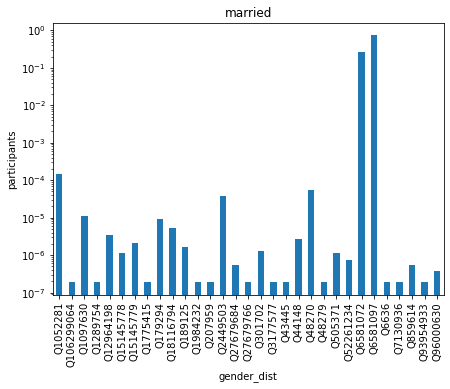

In [14]:
gender_dist = clean_copy.groupby('gender').size()
gender_dist = gender_dist.div(gender_dist.sum(axis=0), axis=0)
pl = gender_dist.plot(kind='bar', figsize=[7,5])
pl.set_title('married')
pl.set_ylabel('participants')
pl.set_xlabel('gender_dist')
pl.set_yscale('log')
plt.show()


In [15]:
qid_label.loc[clean_copy['gender'].unique()]

,Label,Description
QID,,
Q6581097,male,"to be used in ""sex or gender"" (P21) to indicat..."
Q6581072,female,"to be used in ""sex or gender"" (P21) to indicat..."
Q179294,eunuch,castrated male human
Q1052281,transgender female,female person who was assigned a different gen...
Q48270,non-binary,range of gender identities that are not exclus...
Q2449503,transgender male,person assigned to the female sex at birth who...
Q18116794,genderfluid,gender identity which doesn't conform to fixed...
Q12964198,genderqueer,range of gender identities that are not exclus...
Q15145779,cisgender female,female person who was assigned female at birth


### Loading and cleaning Quotebank data

In [16]:
quotebank = pd.read_pickle(PATH + 'small_df.pck')
quotebank.head(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
5200000,2020-01-18-041130,The price has moved up considerably from where...,John Murray,"[Q14248464, Q15456175, Q20621123, Q43912232, Q...",2020-01-18 02:51:28,1,"[[John Murray, 0.9178], [None, 0.0727], [Conor...",[https://www.reviewjournal.com/sports/betting/...,E
5200001,2020-04-02-060174,"The price is already up at £ 65,000 upwards. L...",None,[],2020-04-02 20:28:17,2,"[[None, 0.5587], [Chris Woakes, 0.3666], [Jos ...",[http://thedailystar.net/sports/cricket/news/e...,E
5200002,2020-02-04-084580,The primary requirement to prevent and manage ...,None,[],2020-02-04 03:04:09,1,"[[None, 0.9064], [Harsh Vardhan, 0.0936]]",[https://www.thehindubusinessline.com/news/cor...,E
5200003,2020-02-13-091159,The prime minister has a different opinion tha...,Jiří Ovčáček,[Q15290758],2020-02-13 23:50:00,1,"[[Jiří Ovčáček, 0.8658], [None, 0.1116], [Milo...",[http://msn.com/en-au/news/world/czech-prime-m...,E
5200004,2020-03-30-050268,The problem is the number of bank accounts I h...,John Smith,"[Q14948763, Q16225555, Q16674228, Q1701779, Q1...",2020-03-30 05:00:54,2,"[[John Smith, 0.8909], [None, 0.1091]]",[https://www.energyvoice.com/coronavirus/23158...,E


In [17]:
cleaned_quotebank = quotebank.copy(deep=True)
cleaned_quotebank.shape

(44449, 9)

In [18]:
cleaned_quotebank['quotation'].is_unique

True

It appears that there are no duplicate quotations is quotebank dataset.
We will now remove rows with unknown speaker.

In [19]:
cleaned_quotebank = cleaned_quotebank[~cleaned_quotebank.speaker.isin(['None', None])]
print(cleaned_quotebank.shape)

(29140, 9)


Here we drop the rows where the quotebank algorithm is uncertain (probability given for speaker inferior to 50%)

In [20]:
cleaned_quotebank =  cleaned_quotebank[cleaned_quotebank['probas'].apply(lambda x: x[0][1]).values.astype(float) > 0.5]
cleaned_quotebank.shape 

(27786, 9)

### Create a data frame with all information

Let's create data frames with different field of professions to compare men and women quotes without the bias of the professional background.

In [21]:
art_professions = qid_label[qid_label['Label'].str.contains('cineast|painter|musician|sculpter|architect|philosoph|writer|actor|dancer', na=False)]
scientific_professions = qid_label[qid_label['Label'].str.contains('scientific|researcher|mathematician|doctor|astronomist|biologist|chemist|physicist|psychologist|sociologist|engineer|anatomist', na=False)]
# seems like manager is a very bad word discuss with others
economic_professions = qid_label[qid_label['Label'].str.contains('economist|financ|CEO|CTO|chairman|auditor|stockbroker|insurer|business manager|retail merchandizer|pricing analyst|statistician|financial consultant|salesperson', na=False)]
political_professions = qid_label[qid_label['Label'].str.contains('politician|president|minister|government', na=False)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(political_professions)

                                                        Label  \
QID                                                             
Q8758                   2006 Venezuelan presidential election   
Q30461                                              president   
Q45578               2008 United States presidential election   
Q72251               1876 United States presidential election   
Q143304                    2009 Iranian presidential election   
Q176968             Foreign government advisor in Meiji Japan   
Q261881                    2008 Cypriot presidential election   
Q276667               1956 South Korean presidential election   
Q327591                                independent politician   
Q374379                     1995 Polish presidential election   
Q575757              1820 United States presidential election   
Q575819              1856 United States presidential election   
Q588041                    2006 Italian presidential election   
Q624442               197

Example for profession politican only

We now want to merge information of the speaker with our sub-dataframe:

In [24]:
#Example for Politician
target = ['Q82955']
df_politician = create_df_with_conditions('occupation', target, cleaned_wikidata, 'ispolitician')
df_politician.head()

TypeError: cannot perform reduce with flexible type

In [ ]:
#Example for Politician and Painter
target = ['Q82955', 'Q1028181']
df_politician = create_df_with_conditions('occupation', target, cleaned_wikidata, 'ispolitician')
df_politician.head()

In [ ]:
#politician_df.to_pickle("Data/politician.pck")

In [ ]:
#politician_df.head()
politician_df = pd.read_pickle("Data/politician.pck")
politician_df.head()

### Saving data frame useful for processing

In [ ]:
"""vaccination_df.to_pickle("Data/2020_vaccin.pck")
wikidata_all.to_pickle("Data/parquet.pck")
merged_df.to_pickle("Data/merged_df.pck") """

## Processing

In [ ]:
"""VACCINATION_DATASET = PATH+"2020_vaccin.pck"
vaccination = pd.read_pickle(VACCINATION_DATASET)
vaccination"""

Loading the quotes and information about speaker

In [ ]:
#merged_df = pd.read_pickle(PATH+"merged_df.pck")

In [ ]:
#merged_df.head()

# Brouillon de trucs qui peuvent être utils

Si on veut enregistrer dans un fichier txt les quotations pour le classifier 

In [ ]:
quotes = vaccination.quotation.astype(str)
quotes.shape

In [ ]:
text_file = open("MoodDiary.txt", "w")
#Opens or creates the .txt file, sharing the directory of the script#
for ind, quote in enumerate(quotes) : 
    print(quote)
    text_file.write(str(ind) + " " + quote + "\n")

#Writes the variable into the .txt file#
text_file.close()

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

## 2.Having Fun

## For the label of Qid

In [ ]:
from wikidata.client import Client

entity = Client().get('Q6581097', load=True).label
print(entity)

In [ ]:

entity = Client().get('Q82955', load=True)
print(entity.label)

In [ ]:
genre = Client().get(wikidata_all.gender,load=True)